## IMPORTING  LIBRARIES

In [42]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import re
import nltk
from tqdm import tqdm
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Data Visualization

In [43]:
#loading the data
df=pd.read_csv('/content/train.csv')

In [44]:
print(df.shape)   #check the shape of the data

(31962, 3)


In [45]:
print(df.head())

   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation


In [46]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB
None


In [47]:
df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

We can observe that there are more reviews with 0 label i.e. tweet is not racist/sexist.<br>
So our dataset is imbalanced

In [48]:
y_value_counts=df['label'].value_counts()
print("Racist tweets  = ",y_value_counts[1], "with percentage ", (y_value_counts[1]*100)/(y_value_counts[0]+y_value_counts[1]),'%')
print("Not Racist tweets  = ",y_value_counts[0], "with percentage ", (y_value_counts[0]*100)/(y_value_counts[0]+y_value_counts[1]),'%')

Racist tweets  =  2242 with percentage  7.014579813528565 %
Not Racist tweets  =  29720 with percentage  92.98542018647143 %


<BarContainer object of 2 artists>

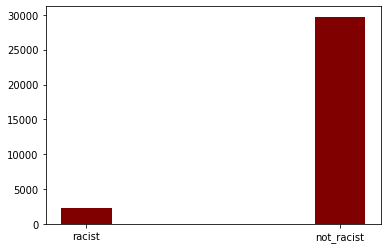

In [49]:
#lets see the classes through bar graph

data=dict(racist=y_value_counts[1],not_racist=y_value_counts[0])
cls=data.keys()
value=data.values()

plt.bar(cls,value,color='maroon',width=0.2)

***From the bar graph we can clearly see that there are more not racist tweets than the racist tweets.***

## Data Preprocessing

Since the data is in text format, we have to preprocess the data and clean the data to vectorize the data.

First we will replace the all blank spaces, - with underscore and convert all the letters to lower case.

In [51]:
df['tweet']=df['tweet'].str.replace(' ','_')
df['tweet']=df['tweet'].str.replace('-','_')
df['tweet']=df['tweet'].str.lower()

In [53]:
#This function will replace english short notations with full form
def expand(sent):
    
    
    sent=re.sub(r"can't", "can not",sent)
    sent=re.sub(r"won't", "will not",sent)
    
    sent=re.sub(r"n\'t", " not",sent)
    sent=re.sub(r"\'re", " are",sent)
    sent=re.sub(r"\'m"," am",sent)
    sent=re.sub(r"\'s"," is",sent)
    sent=re.sub(r"\'ll"," will",sent)
    sent=re.sub(r"\'ve"," have",sent)
    sent=re.sub(r"\'d"," would",sent)
    sent=re.sub(r"\'t", " not",sent)
    
    return sent
    

In [55]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'

stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [56]:
#function for preprocess the text data

def preprocess_tweet(text):
    
    
    preprocessed_tweet=[]
    
    for sentence in tqdm(text):
        sent=expand(sentence)
        sent=sent.replace("\\r"," ")
        sent=sent.replace("\\n"," ")
        sent=sent.replace('\\"'," ")
        sent=re.sub("[^A-Za-z0-9]+"," ",sent)
        
        
        sent=" ".join(i for i in sent.split() if i.lower() not in stopwords)
        preprocessed_tweet.append(sent.lower().strip())
        
    return preprocessed_tweet
        

In [57]:
preprocessed_tweets=preprocess_tweet(df['tweet'].values)

100%|██████████| 31962/31962 [00:01<00:00, 17702.02it/s]


In [58]:
df['tweet']=preprocessed_tweets

In [59]:
df["tweet"][10]

'ireland consumer price index mom climbed previous 0 2 0 5 may blog silver gold forex'

##### Now the text data is cleaned

### Splitting data into train and test

In [60]:
y=df['label']
x=df.drop(['label'],axis=1)

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,stratify=y,random_state=40)


### Vectorization

#### TFIDF for text data

In [62]:
vect=TfidfVectorizer(min_df=10)

vect.fit(x_train['tweet'].values)

train_tweet=vect.transform(x_train['tweet'].values)
test_tweet=vect.transform(x_test['tweet'].values)

print(train_tweet.shape,y_train.shape)
print(test_tweet.shape,y_test.shape)

(25569, 2763) (25569,)
(6393, 2763) (6393,)


In [63]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [64]:
#calculating sentiment scores for train data

x_train_sent=np.ndarray.tolist(x_train["tweet"].values)

sia=SentimentIntensityAnalyzer()
ps=[]
for i in range(len(x_train_sent)):
    ps.append((sia.polarity_scores((x_train_sent[i]))))
    
x_train_polarity=np.array(ps)
x_train_polarity=x_train_polarity.reshape(-1,1)
x_train_polarity.shape


(25569, 1)

In [66]:
#storing only scores of sentiment

x_t=[]
for i in range(len(x_train)):
    for j in x_train_polarity[0][0]:
        x_t.append(x_train_polarity[i][0][j])
x_t=np.array(x_t)
x_t=x_t.reshape(-1,4)
x_t.shape

(25569, 4)

In [67]:
#calculating sentiment scores for test data

x_test_sent=np.ndarray.tolist(x_test["tweet"].values)

sia=SentimentIntensityAnalyzer()
ps=[]
for i in range(len(x_test_sent)):
    ps.append((sia.polarity_scores((x_test_sent[i]))))
    
x_test_polarity=np.array(ps)
x_test_polarity=x_test_polarity.reshape(-1,1)
x_test_polarity.shape


(6393, 1)

In [68]:
#storing only scores of sentiment

x_tests=[]
for i in range(len(x_test)):
    for j in x_test_polarity[0][0]:
        x_tests.append(x_test_polarity[i][0][j])
x_tests=np.array(x_tests)
x_tests=x_tests.reshape(-1,4)
x_tests.shape

(6393, 4)

##### Convert the vectors into scipy.sparse matrix

In [69]:
from scipy.sparse import hstack

In [70]:
x_tr=hstack((train_tweet,x_t))
x_te=hstack((test_tweet,x_tests))

print(x_tr.shape)
print(x_te.shape)

(25569, 2767)
(6393, 2767)


***Now we are ready with the data.***

### DecisionTreeClassifier()

In [71]:
#since the data is imbalanced , we assign some more weight to class 1

wt={0:1,1:5}   
clf=DecisionTreeClassifier(class_weight=wt)

parameters=dict(max_depth=[1,5,10,50],min_samples_split=[5,10,100,500])

search=RandomizedSearchCV(clf,parameters,random_state=10)
result=search.fit(x_tr,y_train)
result.cv_results_

{'mean_fit_time': array([0.10959167, 0.02849193, 0.9515389 , 0.10021701, 0.09959207,
        0.20591493, 0.19249821, 0.02770481, 0.18987908, 1.03148174]),
 'mean_score_time': array([0.00204287, 0.00185456, 0.00263848, 0.00162048, 0.00167136,
        0.00176573, 0.00171633, 0.00162554, 0.00186882, 0.00280166]),
 'mean_test_score': array([0.90625359, 0.81841286, 0.91145538, 0.90527585, 0.90578428,
        0.9210375 , 0.9186518 , 0.81841286, 0.91724389, 0.92921114]),
 'param_max_depth': masked_array(data=[5, 1, 50, 5, 5, 10, 10, 1, 10, 50],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[10, 500, 100, 500, 100, 5, 100, 100, 500, 5],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 5, 'min_sam

In [72]:
search.best_params_

{'max_depth': 50, 'min_samples_split': 5}

In [74]:
cls = DecisionTreeClassifier(max_depth=50,min_samples_split=5,random_state=10,class_weight=wt)
cls.fit(x_tr,y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 5}, max_depth=50,
                       min_samples_split=5, random_state=10)

In [76]:
y_pred_train=cls.predict(x_tr)
y_pred_test=cls.predict(x_te)

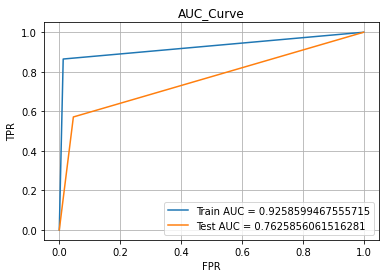

In [31]:
train_fpr,train_tpr,tr_treshold=roc_curve(y_train,y_pred_train)
test_fpr,test_tpr,te_treshold=roc_curve(y_test,y_pred_test)

train_auc=auc(train_fpr,train_tpr)
test_auc=auc(test_fpr,test_tpr)

plt.plot(train_fpr,train_tpr,label='Train AUC = '+str(train_auc))
plt.plot(test_fpr,test_tpr,label='Test AUC = '+str(test_auc))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("AUC_Curve")
plt.grid()
plt.show()

***We got auc score= 0.7625***

In [77]:
#best threshold value that will give the least fpr

def find_best_threshold(threshold, fpr, tpr):

    t = threshold[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if our fpr is very low and tpr is very high

    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    
    return t

#this will give predictions based on best threshold value

def predict_with_best_t(proba, threshold):

    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [79]:
#computing confusion matrix for set_1

from sklearn.metrics import confusion_matrix

best_t = find_best_threshold(tr_treshold, train_fpr, train_tpr)
print("Train confusion matrix")

m_tr=(confusion_matrix(y_train, predict_with_best_t(y_pred_train, best_t)))
print(m_tr)
print("Test confusion matrix")

m_te=(confusion_matrix(y_test, predict_with_best_t(y_pred_test, best_t)))
print(m_te)

the maximum value of tpr*(1-fpr) 0.6836258729003208 for threshold 1
Train confusion matrix
[[23470   305]
 [  243  1551]]
Test confusion matrix
[[5670  275]
 [ 192  256]]


In [80]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      5945
           1       0.48      0.57      0.52       448

    accuracy                           0.93      6393
   macro avg       0.72      0.76      0.74      6393
weighted avg       0.93      0.93      0.93      6393



## NAIVE BAYES

### CountVectorizer()

In [82]:
vec=CountVectorizer(min_df=10)
vec.fit(x_train['tweet'].values)

x_tr_count=vec.transform(x_train['tweet'].values)
x_te_count=vec.transform(x_test['tweet'].values)
x_tr_count.shape

(25569, 2763)

In [83]:
x_tr_data=hstack((x_tr_count,x_t))
x_te_data=hstack((x_te_count,x_tests))

x_trn=scipy.sparse.csr_matrix(x_tr_count)
x_tst=scipy.sparse.csr_matrix(x_te_count)

In [84]:
from sklearn.naive_bayes import MultinomialNB

In [85]:
mod = MultinomialNB()
mod.fit(x_trn,y_train)

MultinomialNB()

In [86]:
train_pred=mod.predict(x_trn)
test_pred=mod.predict(x_tst)

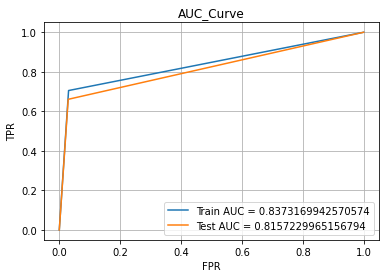

In [87]:
train_fpr,train_tpr,tr_treshold=roc_curve(y_train,train_pred)
test_fpr,test_tpr,te_treshold=roc_curve(y_test,test_pred)

train_auc=auc(train_fpr,train_tpr)
test_auc=auc(test_fpr,test_tpr)

plt.plot(train_fpr,train_tpr,label='Train AUC = '+str(train_auc))
plt.plot(test_fpr,test_tpr,label='Test AUC = '+str(test_auc))
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("AUC_Curve")
plt.grid()
plt.show()

***TEST AUC = 0.8157***

In [88]:
#get the summary of this model

print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      5945
           1       0.63      0.66      0.64       448

    accuracy                           0.95      6393
   macro avg       0.80      0.82      0.81      6393
weighted avg       0.95      0.95      0.95      6393



## SUMMARY

|MODEL|TEST AUC|
|----|----|
|DECISION TREE|0.7625|
|NAIVE BAYES|0.8157|
